# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### Define the problem

Organisations find it difficult to know what is the correct salary to offer therefore the goal of this project is to examine a dataset of different job postings to predict the salary of a new set of job postings. 

To help predict the salaries, there are several features that will be considered such as: 

- The company 
- The type of job e.g. manager, CFO etc.
- The type of degree e.g. high school, doctoral, etc.
- The degree subject e.g. maths, physics, etc.
- The different industry e.g. healthcare, oil, etc. 
- Years of experience
- Miles From Metropolis

In [1]:
#import libraries
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



__author__ = "Pooja Patel"
__email__ = "poojapatel1997@hotmail.com"

## Part 2 - DISCOVER

### Load the data 

In [3]:
#load the data into a Pandas dataframe

#Training Dataframes
FeaturesTrain = pd.read_csv(r"/Users/Pooja/Documents/Projects/Salary Prediction/train_features.csv")
SalaryTrain = pd.read_csv(r"/Users/Pooja/Documents/Projects/Salary Prediction/train_salaries.csv")

#Testing Dataframes
FeaturesTest = pd.read_csv(r"/Users/Pooja/Documents/Projects/Salary Prediction/test_features.csv")


In [4]:
#view the two training datasets to see how we can join the dataframes
FeaturesTrain.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [5]:
SalaryTrain.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [6]:
#Both the dataframes have the jobid column so can join on this column to create a new dataframe

Traindf = FeaturesTrain.merge(SalaryTrain, on = 'jobId')
Traindf.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
Traindf.shape

(1000000, 9)

### Clean the data

#### Clean data for training dataframe

In [8]:
#check if there are any duplicates in the data 

Traindf.drop_duplicates(subset ="jobId", keep = False, inplace = True)
Traindf.shape
#No duplicates found in the data 

(1000000, 9)

In [9]:
#Check if there are invalid data (Salary should be greater than 0)

Traindf = Traindf.drop(Traindf[Traindf.salary <= 0].index) 
Traindf.shape #this tells us that there were 5 data points where the salary was equal to or below 0

(999995, 9)

In [10]:
#Remove columns with missing values 

Traindf = Traindf.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
Traindf.shape #no missing values in data 

(999995, 9)

In [12]:
#### Compare the data types for both the training and testing data to ensure it makes sense
Traindf.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

### Explore the data (EDA) 

#### Plot the features 

In [14]:
#define a function to plot both the numeric and categorical features in the dataset 
def feature_plot(df, col):
    #state the plot size 
    plt.figure(figsize = (14, 6))
    #plot one of two plots 
    plt.subplot(1, 2, 1)
    
    #if column is numeric then plot the following:

    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #if column is not numeric then plot the following:
        sns.countplot(x=col, data=df)
        
    #set the labels on the axis 
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    
    #plot two plot
    plt.subplot(1, 2, 2)
    #if column is numeric then plot the following:
    if df[col].dtype == 'int64':
        mean = df.groupby(col)['salary'].mean()
        mean.plot()
        
    else:
        #if column is not numeric then plot the following:

        sns.boxplot(x = col, y = 'salary', data=df)
        
    #set the labels on the axis    
    plt.xticks(rotation = 45)
    plt.ylabel('Salaries')
    plt.show()
    

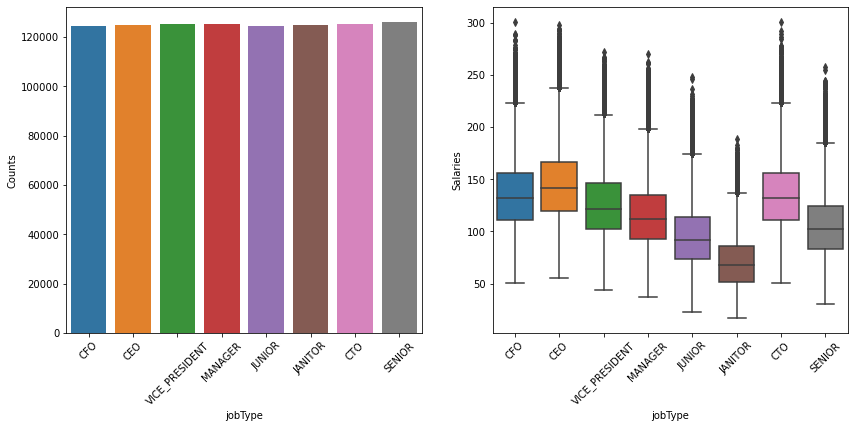

In [15]:
feature_plot(Traindf, 'jobType')

#### Conclusions: 

- All job types roughly have a similar count in the data
- From the boxplot, Janitors generally have lower salaries compared to the other job types and CEO/CTO have higher salaries compared to other job types
- From this, there is a relationship between salaries and job types

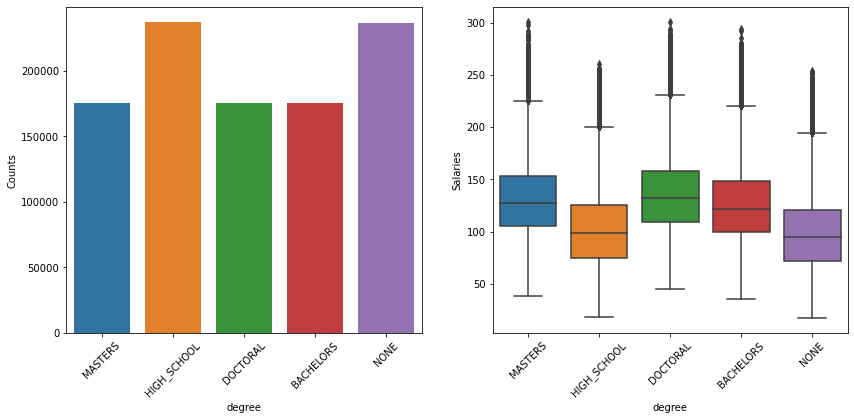

In [16]:
feature_plot(Traindf, 'degree')

#### Conclusions: 

- Masters and High-school degree types tend to be more popular
- From the boxplot, people with no degrees and in high school generally have lower salaries compared to the other degree types
- From this, there is a relationship between salaries and degree types

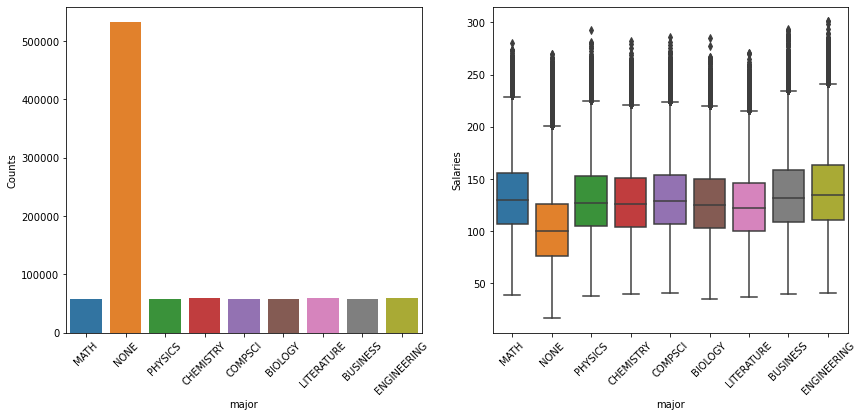

In [17]:
feature_plot(Traindf, 'major')

#### Conclusions: 

- 'None' major tend to be most popular
- From the boxplot, people who have 'none' major generally have lower salaries compared to the other majors
- From this, there is a relationship between salaries and degree types

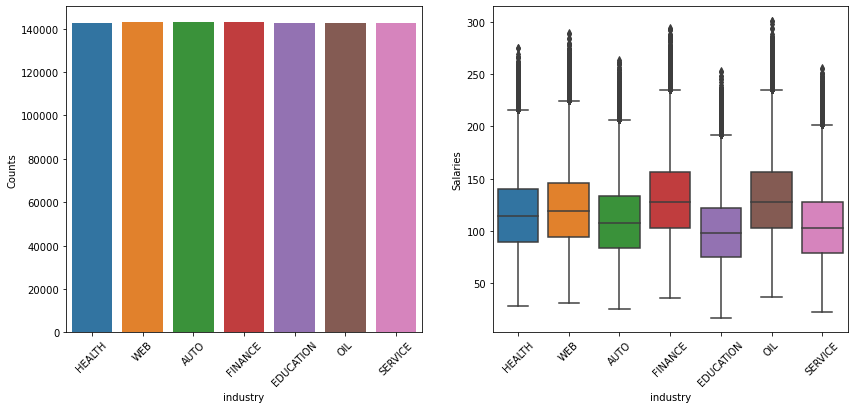

In [18]:
#Plots for different industires
feature_plot(Traindf, 'industry')

#### Conclusions: 

- There are roughly equal counts of each industry within the data
- From the boxplot, people with who work in the finance and oil industries generally have higher salaries compared to the other degree types
- From this, there is a relationship between salaries and degree types

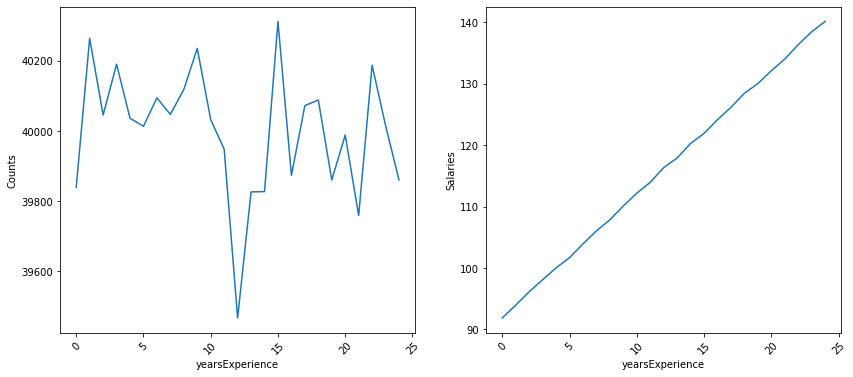

In [19]:
feature_plot(Traindf, 'yearsExperience')

#### Conclusions: 

- From this, there is a positve linear relationship between salaries and number of years experience one has
- Therefore the more experience you have, the higher the salary 


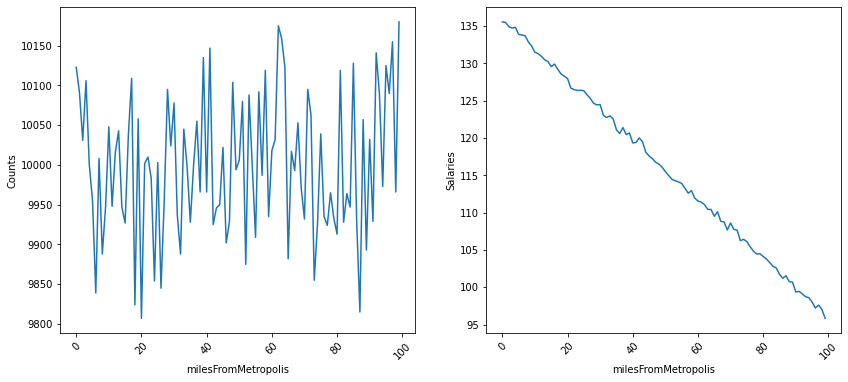

In [20]:
feature_plot(Traindf, 'milesFromMetropolis')

#### Conclusions: 

- From this, there is a negative linear relationship between salaries and number of miles from Metropolis
- Therefore the further you live from Metropolis, the lower the salary you would recieve

#### Plot the target variable

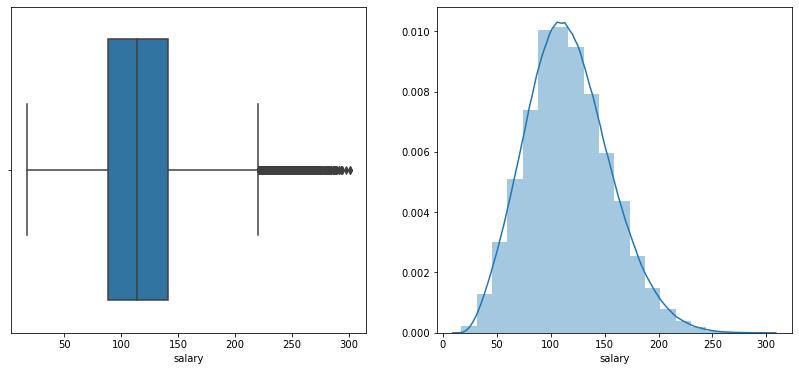

In [21]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(Traindf.salary)
plt.subplot(1,2,2)
sns.distplot(Traindf.salary, bins=20)
plt.show()

#### Conclusions: 

- From the boxplot and histogram we see that most values lie between 70k to 150k
- The salary histogram plot has right skewness

#### Overall summary of data
- Overall the dataset is balanced as each category in the categorical features has almost same number of records. However, for in the 'Major' feature, the count is much higher for 'None' category compared to the other categories.

#### Create a correlation matrix

In [22]:
#create a duplicate of training dataset to help find correlations between features
corr_data = Traindf.copy()

In [23]:
# define a function to encode the categorical variables 
def Encode_Data(dataframe):   
    for col in dataframe.columns:        
        if dataframe[col].dtype.name == "category" or "object":
            le = LabelEncoder()
            dataframe[col]=le.fit_transform(dataframe[col])
    return dataframe

In [24]:
#check that the data is encoded correctly 
EncodedData = Encode_Data(corr_data)
EncodedData

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,113
1,1,11,0,2,7,6,3,73,84
2,2,48,7,1,8,3,10,38,120
3,3,32,5,1,2,0,8,17,125
4,4,60,7,0,8,2,8,16,146
...,...,...,...,...,...,...,...,...,...
999995,999990,52,7,0,2,3,19,94,71
999996,999991,17,2,2,7,2,12,35,143
999997,999992,16,4,2,7,1,16,81,47
999998,999993,23,1,3,7,3,6,5,132


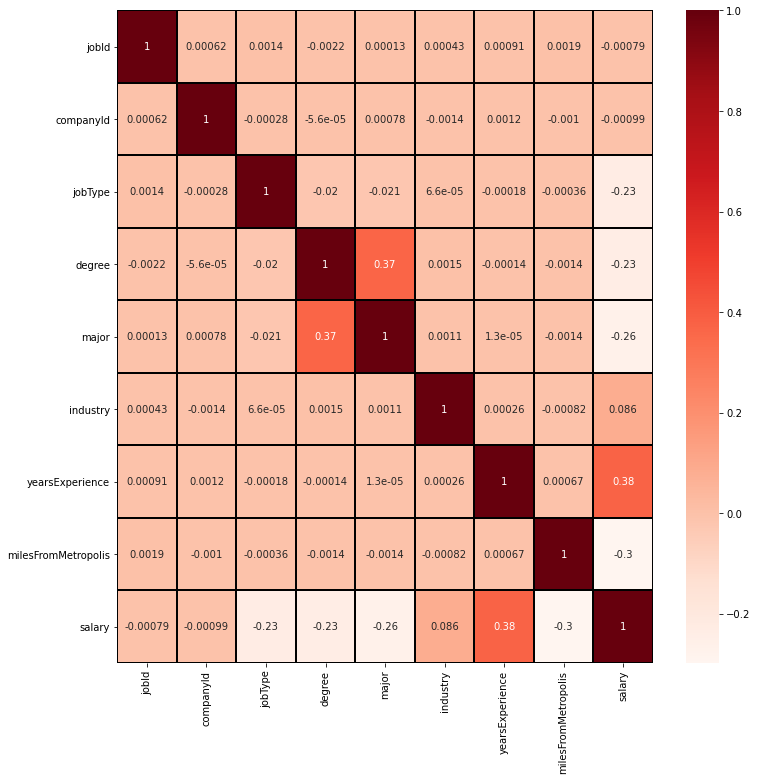

In [25]:
#Create a correlation matrix to see which features (including the salary target variable) are correlated with each other
plt.figure(figsize=(12,12))
corr = EncodedData.corr()
sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,cmap="Reds",annot=True,linewidths=1,linecolor='black')
plt.show()

#### Conclusions 

- Features correlated with Salary (target variable)
    - positive correlation with years of experience. Years of experiencce has the strongest correlation with salary
    - negative correlation with miles from Metropolis, major, degree and job type
    - very little correlation with job id, company id and industry
    
- Feature correlation: 
    - Major and degree are the most correlated. They have a positive correlation
    - The other features don't seem to have much of a correlation

### Establish a baseline

The baseline model I will use for this analysis is a simple linear regression, with the most correlated feature to the salary target variable. In this case the variable I will use is the number of experience one has. 

In [26]:
# state parameters
x= EncodedData[['yearsExperience']]
y = EncodedData[['salary']]

#use the linear regression method 
modelSLR = LinearRegression()

#fit the model
modelSLR.fit(x,y)


LinearRegression()

In [27]:
#look at the intercept and coefficent

interceptSLR = modelSLR.intercept_[0]
coefficientSLR = modelSLR.coef_[0][0]

print("The intercept for our model is "  + str(interceptSLR))
print("The coefficient for our model is "  + str(coefficientSLR))

The intercept for our model is 74.92019493794606
The coefficient for our model is 2.0131222573053162


In [28]:
SLR_crossval_mse = cross_val_score(modelSLR, x, y, scoring = 'neg_mean_squared_error', cv =5)
SLR_crossval_mse.mean()

-1288.2046053605968

In [29]:
# negative mean squared error is 

### Hypothesize solution 

#### Models to improve baseline Model 

<b> Model 1 - Multiple Linear Regression </b> 

- This could be an improvement on the baseline model because in the baseline model only includes one feature which was the Years of Experience one has to predict the salary and multiple regression will include several features.

- Model: $\hat{y}_{i} = {\beta}_{0} + {\beta}_{1}x_{i1} + {\beta}_{2}x_{i2} + ... + {\beta}_{p}x_{i1} + {\epsilon} $ <br>
    where <br>
    ${y}_{i}$ = dependent variable<br>
    ${x}_{i}$ = expanatory variables <br>
    ${\beta}_{0}$ = constant term (y-intercept) <br>
    ${\beta}_{p}$ = slope coefficients for each explanatory variable <br>
    ${\epsilon} $ = model error (residuals)

<b> Model 2 - Random Forest Regression </b> 

- Random Forest is a collection of decision trees
- This model does not rely too heavily on an individual procedure therefore it makes fair use of all potential predictive features
- Random Forest is a bagging ensembling technique and it handles overfitting, reduces variance and are independent classifers.

<b> Model 3 - Gradient Boosting Regression </b>

- As the data contains weakly correlated features, gradient boosting regression combines weak learners into a single strong learner, which could be an improvement to the baseline model

All three models are supervised algorithms 

## Part 3 - DEVELOP

### Engineer features 

- 'jobId' is a feature that is unique to each and every record in the data - not considered for modeling as it will not have any impact on the model
- companyId has a very weak correlation with all the other features including the target variable therefore will not be considered in the model
- 'jobType', 'degree', 'major', 'industry' are categorical features, one-hot encoding will be applied on these features

In [30]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

#Previously, when the correlation matrix was calculated, we encoded the data to turn the categorical data into numeric values.
#use the copy function to get the encoded data

TrainingData = corr_data.copy()
TrainingData #can see all the data is encoded 

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,113
1,1,11,0,2,7,6,3,73,84
2,2,48,7,1,8,3,10,38,120
3,3,32,5,1,2,0,8,17,125
4,4,60,7,0,8,2,8,16,146
...,...,...,...,...,...,...,...,...,...
999995,999990,52,7,0,2,3,19,94,71
999996,999991,17,2,2,7,2,12,35,143
999997,999992,16,4,2,7,1,16,81,47
999998,999993,23,1,3,7,3,6,5,132


In [31]:
# Drop jobId and companyId 
TrainingData = TrainingData.drop(columns =['jobId', 'companyId'])
TrainingData

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,1,3,6,3,10,83,113
1,0,2,7,6,3,73,84
2,7,1,8,3,10,38,120
3,5,1,2,0,8,17,125
4,7,0,8,2,8,16,146
...,...,...,...,...,...,...,...
999995,7,0,2,3,19,94,71
999996,2,2,7,2,12,35,143
999997,4,2,7,1,16,81,47
999998,1,3,7,3,6,5,132


In [32]:
target = TrainingData['salary']
TrainingData = TrainingData.drop('salary',axis=1)

### Create models

In [33]:
#create and tune the models that you brainstormed during part 2
#initialize model list and dicts
models = []
mean_mse = {}
cv_std = {}

In [34]:
x1 = TrainingData
y1 = target

x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y1, test_size=0.2)

In [35]:
lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=200, n_jobs=4, max_depth=30, 
                           min_samples_split=60, max_features='auto', verbose=0)
gbr = GradientBoostingRegressor(n_estimators=160, max_depth=6, loss='ls',verbose=0)

In [36]:
def training_model(model,x1_train,y1_train, mean_mse, cv_std):
    print('\033[1m'+ 'Model Name: \n' + '\033[0m',model)
    neg_mse= cross_val_score(model,x1_test,y1_test,cv=5,scoring='neg_mean_squared_error')
    mean_mse[model] = np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    print('\033[1m' + 'Average Negative Mean Squared Error:\n' + '\033[0m', mean_mse[model])
    print('\033[1m' + 'Standard Deviation:\n' + '\033[0m', cv_std[model])

In [37]:
#Evaluate models with 5 fold cross validation
models.extend([lr, rfr, gbr])
for m in models: 
    training_model(m, x1_train, y1_train, mean_mse, cv_std)

Model Name: 
 LinearRegression()
Average Negative Mean Squared Error:
 -925.6496082829553
Standard Deviation:
 4.869762307191581
Model Name: 
 RandomForestRegressor(max_depth=30, min_samples_split=60, n_estimators=200,
                      n_jobs=4)
Average Negative Mean Squared Error:
 -389.60361517206604
Standard Deviation:
 3.2793509493211745
Model Name: 
 GradientBoostingRegressor(max_depth=6, n_estimators=160)
Average Negative Mean Squared Error:
 -358.12868636485985
Standard Deviation:
 2.287293500025324


### Select best model 

In [44]:
#select the model with the highest error as the "prodcuction" model
#use max function because using negative MSE and therefore want it as big as possible
bestmodel = max(mean_mse, key=mean_mse.get) 
print('\nBest model is: \n', bestmodel)


Best model is: 
 GradientBoostingRegressor(max_depth=6, n_estimators=160)


## Part 4 - DEPLOY

### Automate pipeline

In [45]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

#Fit model on the entire training test using the best model

bestmodel.fit(x1,y1)

GradientBoostingRegressor(max_depth=6, n_estimators=160)

In order to test the model, the testing data needs to be in the same format as the training data. 

Therefore to get it to the same format, it needs to undergo the following:

1. Check the data types and ensure it matches 
2. Encode the categorical features 

In [57]:
# First check the data types 
FeaturesTest.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [58]:
FeaturesTest.shape

(1000000, 8)

In [62]:
# To encode the categorical features, use the function defined above called 'Encode_Data'

Encode_Data(FeaturesTest)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,0,27,5,2,7,3,22,73
1,1,5,4,4,7,0,20,47
2,2,2,2,3,0,3,17,9
3,3,14,5,2,7,4,14,96
4,4,30,4,1,0,4,10,44
...,...,...,...,...,...,...,...,...
999995,999995,50,7,0,6,4,14,3
999996,999996,45,5,4,7,3,20,67
999997,999997,58,3,4,7,4,1,91
999998,999998,11,2,1,6,4,14,63


The code looks like it is correctly encoded

In [69]:
# Need to drop jobId and companyId as these columns were not used to build the model

test = FeaturesTest.drop(columns=['jobId', 'companyId'],axis=1)
test

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,5,2,7,3,22,73
1,4,4,7,0,20,47
2,2,3,0,3,17,9
3,5,2,7,4,14,96
4,4,1,0,4,10,44
...,...,...,...,...,...,...
999995,7,0,6,4,14,3
999996,5,4,7,3,20,67
999997,3,4,7,4,1,91
999998,2,1,6,4,14,63


In [85]:
# Can now start making predictions using the model

predictions = bestmodel.predict(test)
predictions

array([ 93.50706571,  75.56334577, 164.5277813 , ...,  38.46937575,
       145.86821008,  96.94982204])

### Deploy solution 

To deploy this solution, the predictions will be saved into a csv file and some visualisations to summarise the predictions

In [86]:
test['Salary Predictions'] = predictions.tolist()

In [87]:
test

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,Salary Predictions
0,5,2,7,3,22,73,93.507066
1,4,4,7,0,20,47,75.563346
2,2,3,0,3,17,9,164.527781
3,5,2,7,4,14,96,85.589977
4,4,1,0,4,10,44,99.629212
...,...,...,...,...,...,...,...
999995,7,0,6,4,14,3,149.017932
999996,5,4,7,3,20,67,90.219908
999997,3,4,7,4,1,91,38.469376
999998,2,1,6,4,14,63,145.868210


In [108]:
test.to_csv(r'Salary Prediction.csv', index = False)

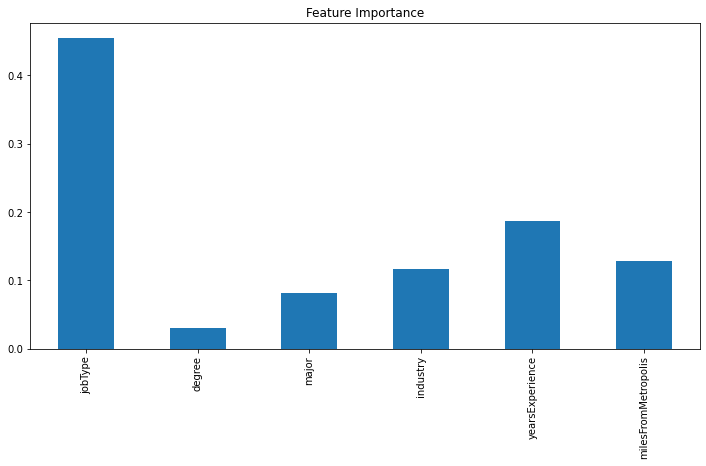

In [109]:
importances = pd.Series(bestmodel.feature_importances_, index=TrainingData.columns)
importances.plot(kind='bar', figsize=(12,6))
plt.title("Feature Importance")
plt.savefig('Feature Importance.png')
plt.show()

